# Sentiment Classification with Pretrained Glove Word Embeddings and LSTM
This notebook contains the code for training and testing a sentiment classifier on IMDB movie reviews dataset from Kaggle.

Dataset: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Features: Word Embeddings

Classifier: LSTM

## Importing Libraries and loading dataset

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

dataset_path = "../Speculation-Dataset/nspec_train.tok"
# dataset_path = "dataset/imdb_dataset.csv"
movie_reviews = pd.read_csv(dataset_path)

movie_reviews.isnull().values.any()
movie_reviews.head()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


,This publication led to a string of subsequent findings it was shown that the RNAi mechanism is conserved in Drosophila and can be achieved by injection of dsRNA into embryos or simple addition to cultured cells Kennerdell that RNAi is mediated by small -nucleotide nt-long intermediates Tuschl and that synthetic -nt small interfering si RNA can be used for knockdown studies in mammalian cells Elbashir .
0,Dcp- is an effector caspase and it has been pr...
1,It has been shown previously that an important...
2,In addition by specifically eliminating nos or...
3,CRMs can thus be thought of as sitting at the ...
4,Two other regulatory genes which were found to...


## Sentiment Distribution in dataset

<AxesSubplot:xlabel='sentiment', ylabel='count'>

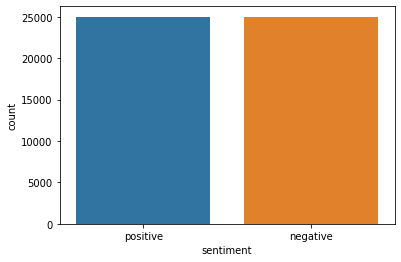

In [3]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

## Cleaning and preparing dataset for training

In [5]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

print(X[:5])
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

['One of the other reviewers has mentioned that after watching just Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare Forget pretty pictur

## Creating Train Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Tokenizing dataset

In [8]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[0])

[9, 43, 786, 2121, 524, 299, 1, 104, 1860, 1989, 4281, 2, 782, 4786, 9, 1, 224, 1, 77, 763, 51, 49, 17, 97, 3, 1, 24, 1968, 98, 31, 23, 32, 116, 1101, 9, 6, 5, 2323, 1163, 4, 449, 43, 540, 4, 88, 28, 20, 37, 892, 397, 13, 1, 154, 4, 2935, 22, 4318, 18, 2897, 9, 42, 71, 218, 69, 123, 7, 76, 3100, 193, 18, 232, 2, 1, 427, 198, 4888, 147, 19, 60, 24, 13, 70, 358, 299, 16, 15, 6, 198, 25, 302, 9, 11, 1, 1820, 112, 413, 2, 11, 1, 1651, 562, 67, 419, 373, 82, 114, 43, 110, 361, 28, 33, 15, 41, 10, 88, 441, 13, 357, 1145, 59, 7, 1, 460, 214, 992, 4, 4124, 7, 174, 3, 32, 433, 680, 607, 9, 66, 227, 233, 107, 830, 33, 169, 27, 217, 9, 1, 423, 360, 53, 3696, 273, 157, 1672, 187, 5, 1, 711, 1904, 1, 1177, 3, 2838, 3672, 1652, 2, 144, 147, 225, 3, 203, 320, 2, 147, 1052, 14, 85, 3, 131, 2790, 15, 152, 95, 3, 1, 3974, 299, 8, 12, 975, 33, 1, 485, 2567, 242, 66, 72, 104, 104, 678, 57, 80, 66, 148, 1331, 4, 223, 131, 20, 4319, 29, 137, 205, 1123, 11, 4341, 29, 2276, 2, 7, 8, 5, 438, 11, 610, 3, 1, 703

## Padding sequences

In [36]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Creating embedding dictionary using Pretrained Glove word embeddings

In [37]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('pretrained/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

## Initiazling Word Embeddings
We use pretrained word embeddings for the tokens for which it is available. For other tokens, we initialize them with 0s.

In [39]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Creating Deep Learning Model

In [41]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


## Training Model


In [42]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 38s 149ms/step - loss: 0.6114 - acc: 0.6452 - val_loss: 0.4542 - val_acc: 0.7865
Epoch 2/6
250/250 [==============================] - 61s 245ms/step - loss: 0.4664 - acc: 0.7804 - val_loss: 0.4450 - val_acc: 0.7971
Epoch 3/6
250/250 [==============================] - 46s 184ms/step - loss: 0.4183 - acc: 0.8091 - val_loss: 0.3826 - val_acc: 0.8290
Epoch 4/6
250/250 [==============================] - 40s 159ms/step - loss: 0.3776 - acc: 0.8303 - val_loss: 0.4071 - val_acc: 0.8060
Epoch 5/6
250/250 [==============================] - 39s 157ms/step - loss: 0.3624 - acc: 0.8382 - val_loss: 0.3548 - val_acc: 0.8479
Epoch 6/6
250/250 [==============================] - 38s 150ms/step - loss: 0.3351 - acc: 0.8545 - val_loss: 0.3558 - val_acc: 0.8490


## Evaluating Model

313/313 [==============================] - 5s 17ms/step - loss: 0.3516 - acc: 0.8460
Test Score: 0.35157474875450134
Test Accuracy: 0.8460000157356262


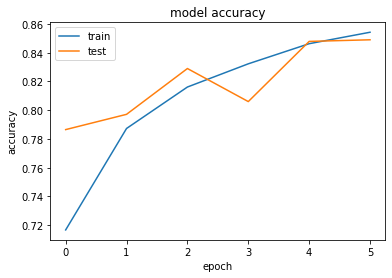

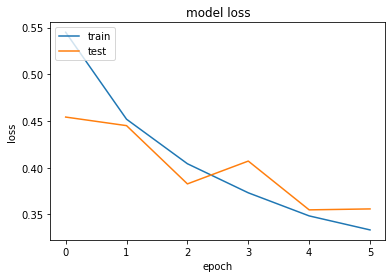

In [43]:

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()